In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import emcee
import corner
import scipy.stats as stats

import sys
sys.path.append("../")
from pyACC.cosmology import Dc_w0waCDM

## Hubble Parameter $ H(z) $ for the $w_0 w_a$ CDM Model

The Hubble parameter is

$$
H(z) = H_0 \sqrt{\Omega_m (1+z)^3 + \Omega_k (1+z)^2 + \Omega_{\Lambda} e^{\left[ 3 \int_0^z \frac{w(z')}{1+z'} \, dz' \right]}}
$$

where the dark energy equation of state $ w(z) $ in the CPL parametrization is

$$
w(z) = w_0 + w_a \frac{z}{1+z}
$$

and

$$
3 \int_0^z \frac{w(z')}{1+z'} \, dz' = 3 \left[ w_0 \ln(1+z) - w_a \frac{z}{1+z} \right]
$$

Thus, $ H(z) $ becomes:

$$
H(z) = H_0 \sqrt{\Omega_m (1+z)^3 + \Omega_k (1+z)^2 + \Omega_{\Lambda} (1+z)^{3(1+w_0 + w_a)} e^{\left(-3 w_a \frac{z}{1+z} \right)}}
$$

For a flat universe ($\Omega_k = 0$), where $\Omega_\Lambda = 1 - \Omega_m - \Omega_r$, this simplifies to:

$$
H(z) = H_0 \sqrt{\Omega_m (1+z)^3 + \Omega_r (1+z)^4 + (1-\Omega_{m}-\Omega_{r}) (1+z)^{3(1+w_0 + w_a)} e^{\left(-3 w_a \frac{z}{1+z} \right)}}
$$

In [18]:
def hubble_function(z,Omega_m,Omega_r,w0,wa,H0):
    return H0*np.sqrt(Omega_m*(1+z)**3+Omega_r*(1+z)**4+(1-Omega_m-Omega_r)*(1+z)**(3*(1+w0+wa))*np.exp(-3*wa*z/(1+z)))

## File `lcparam_full_long.txt`

It contains parameters recovered from light-curve fits for the full Pantheon sample of Type Ia supernovae.

**Columns in the file**

1. **name**: The identifier for the supernova.

2. **zcmb**: The redshift of the supernova in the Cosmic Microwave Background (CMB) frame.

3. **zhel**: The heliocentric redshift of the supernova.

4. **dz**: The uncertainty in the redshift.

5. **mb**: The B-band peak magnitude of the supernova.

6. **dmb**: The uncertainty in the B-band peak magnitude.

7. **x1**: The stretch parameter (describes the shape of the light curve).

8. **dx1**: The uncertainty in the stretch parameter.

9. **color**: The color parameter (describes the color of the supernova).

10. **dcolor**: The uncertainty in the color parameter.

11. **3rdvar**: A third variable related to the supernova (often used for additional corrections).

12. **d3rdvar**: The uncertainty in the third variable.

13. **cov_m_s**: Covariance between the B-band magnitude and the stretch parameter.

14. **cov_m_c**: Covariance between the B-band magnitude and the color parameter.

15. **cov_s_c**: Covariance between the stretch parameter and the color parameter.

16. **set**: The data set the supernova belongs to.

17. **ra**: The right ascension of the supernova.

18. **dec**: The declination of the supernova.

19. **biascor**: The bias correction applied to the supernova data.

*We will only use columns number 2, 4, 5 and 6.*

In [19]:
file_path = 'lcparam_full_long.txt'

with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

z_data = data['zcmb'].values
mb = data['mb'].values #B-band peak magnitude
dmb = data['dmb'].values

Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

## Distance Modulus

The distance modulus $\mu(z)$ is given by
$$
\mu(z) = 5 \log_{10}(d_L(z)) + 25
$$, 
where $d_L(z)$ is the luminosity distance.

The latter can be found by plugging the Hubble parameter $H(z)$ in the $w_0w_a$ CDM model into the integral in
$$
d_L(z) = (1+z) \int_0^z \frac{dz'}{H(z')}
$$.

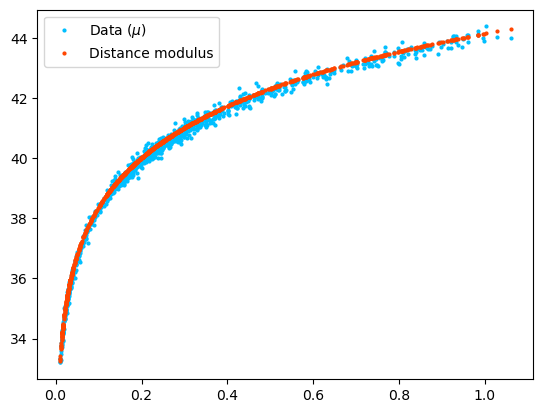

In [20]:
def get_mu(z,H0,Omega_m,Omega_r,w0,wa):
    comoving_distance=[]
    distance_modulus=[]
    
    for i in range(len(z)):
        comoving_distance.append(Dc_w0waCDM(hubble_function,z[i],Omega_m,Omega_r,w0,wa,H0))
        #print(comoving_distance[i])
        if comoving_distance[i]<=0:
            print(f"Invalid distance value: {comoving_distance[i]} for index {i} with redshift {z[i]}")
        distance_modulus.append(5*np.log10(comoving_distance[i]*(1+z[i]))+25)
        #print(distance_modulus[i])
    '''
    for i in range(len(z)):
        # Compute comoving distance
        dc = Dc_w0waCDM(hubble_function, z[i], Omega_m, Omega_r, w0, wa, H0)
        comoving_distance.append(dc)

        # Calculate distance * (1 + z)
        distance = dc * (1 + z[i])
        if distance <= 0:
            print(f"Error at index {i}: Invalid distance value {distance} for comoving_distance {dc} and redshift {z[i]}")
            sys.exit("Stopping execution due to invalid distance value.")

        # Compute distance modulus
        modulus = 5 * np.log10(distance) + 25
        distance_modulus.append(modulus)
    '''
    return np.array(distance_modulus)

#distance modulus of the data: mu_data=mb-M with M the absolute magnitude of a type Ia supernova, so M=-19.3
M=-19.3
mu_data=mb-M

plt.plot(z_data,mu_data,'o',markersize=2,color='deepskyblue',label='Data ($\mu$)')
plt.plot(z_data,get_mu(z_data,68,0.319,0,-1,0),'o',markersize=2,color='orangered',label='Distance modulus')
plt.legend()
plt.show()

### Prior

In [21]:
def log_prior(params):
    H0, Omega_m, Omega_r, w0, wa = params
    if 0 < H0 < 100 and 0.2 < Omega_m < 0.5 and 0 <= Omega_r < 0.1 and -2 < w0 < 0 and -2 < wa < 2:
        return 0
    return -np.inf

### Likelihood

In [22]:
def log_likelihood(params,z,d,cov_inv):
    H0,Omega_m,Omega_r,w0,wa=params
    if H0<0:
        print(f"H0 < 0: {H0}")
        return -np.inf
    if Omega_m<0:
        #print(f"Omega_m out of bounds: {Omega_m}")
        return -np.inf
    if Omega_r<0:
        #print(f"Omega_r out of bounds: {Omega_r}")
        return -np.inf
    mu=get_mu(z,H0,Omega_m,Omega_r,w0,wa)
    diff=d-mu
    #return -0.5 * diff @ cov_inv @ diff
    term1 = -0.5 * diff @ cov_inv @ diff
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    return term1 + term2
    '''
    if np.any(np.isnan(params)):
        print(f"NaN value found in params: {params}")
        return -np.inf
    if len(z)==len(z_data):
        return term1+term2
    else:
        return term1
    '''

### Posterior

In [23]:
def log_posterior(params,z,d,cov_inv):
    prior = log_prior(params)
    '''
    #check for NaNs
    if any(np.isnan(params)):
        print(f"NaNs in params: {params}")
    if np.isnan(prior):
        print(f"NaN in prior: {prior}")
    if np.isnan(log_likelihood(params,z,d,cov_inv)):
        print(f"NaN in likelihood: {log_likelihood(params,z,d,cov_inv)}")
        return prior
    '''
    if np.isfinite(prior):
        return prior + log_likelihood(params,z,d,cov_inv)
    return prior

### $\chi ^2$

In [24]:
def chi(params,z,d,cov_inv):
    return -2*log_posterior(params,z,d,cov_inv)

### Parameter Optimization

In [25]:
initial_guess = [68, 0.319, 0, -0.5, -1]

result = minimize(chi, initial_guess, args=(z_data, mu_data, Sigma_inv), method='Powell')
best_fit_params = result.x

mu_model_best = get_mu(z_data, *best_fit_params)

/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2577: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)


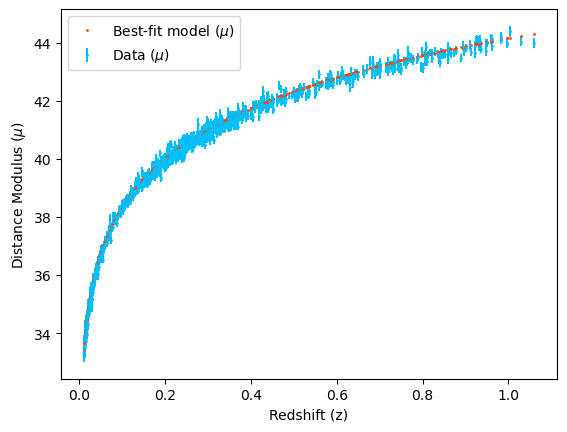

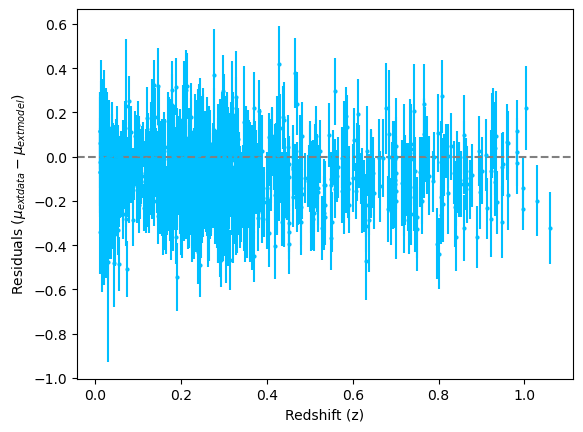

--------------------------------------
Best-fit parameters:
H0: 69.18654433319652
Omega_m: 0.014192350258751
Omega_r: 0.027826223142502646
w0: -0.8541095702035498
wa: 1.1654678582749616
--------------------------------------
Chi-square: 1011.1559407702014
Degrees of freedom: 1017
Reduced chi-square: 0.9942536290759109
--------------------------------------


In [26]:
plt.errorbar(z_data, mu_data, yerr=dmb, fmt='o', markersize=1, color='deepskyblue', label='Data ($\mu$)')
plt.plot(z_data, mu_model_best, 'o', markersize=1, color='orangered', label='Best-fit model ($\mu$)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend()
plt.show()

residuals = mu_data - mu_model_best
plt.errorbar(z_data, residuals, yerr=dmb, fmt='o', markersize=2, color='deepskyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals ($\mu_{\text{data}} - \mu_{\text{model}}$)')
plt.show()

print("--------------------------------------")
print("Best-fit parameters:")
print("H0:", best_fit_params[0])
print("Omega_m:", best_fit_params[1])
print("Omega_r:", best_fit_params[2])
print("w0:", best_fit_params[3])
print("wa:", best_fit_params[4])
print("--------------------------------------")
chi2 = -2 * log_posterior(best_fit_params, z_data, mu_data, Sigma_inv)
print("Chi-square:", chi2)
print("Degrees of freedom:", len(z_data) - len(best_fit_params))
print("Reduced chi-square:", chi2 / (len(z_data) - len(best_fit_params)))
print("--------------------------------------")

## MCMC

In [27]:
# Initialize the MCMC sampler
initial = np.array([68, 0.319, 0, -0.5, -1])
ndim = len(initial)
nwalkers = 50

std_H0= 1e-5
std_Om0 = 1e-2
std_Omr = 1e-7
std_w0_wa = 1e-1

# Create the initial positions with different standard deviations
pos = np.empty((nwalkers, ndim))
pos[:, 0] = initial[0] + std_H0 * np.random.randn(nwalkers)
pos[:, 1] = initial[1] + std_Om0 * np.random.randn(nwalkers)
pos[:, 2] = initial[2] + std_Omr * np.random.randn(nwalkers)
pos[:, 3] = initial[3] + std_w0_wa * np.random.randn(nwalkers)
pos[:, 4] = initial[4] + std_w0_wa * np.random.randn(nwalkers)

#'''
# Check initial likelihoods
for i in range(nwalkers):
    print(log_likelihood(pos[i], z_data, mu_data, Sigma_inv))

# Check initial posteriors
for i in range(nwalkers):
    print(log_posterior(pos[i], z_data, mu_data, Sigma_inv))
#'''

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_data, mu_data, Sigma_inv))

-inf
-568.2524649156405
-inf
-inf
-inf
-605.4999623388906
-inf
-627.4632980977278
-inf
-inf
-inf
-598.28069645011
-inf
-inf
-inf
-617.2643733823245
-558.8710825825094
-inf
-inf
-inf
-586.4959490390922
-inf
-inf
-569.209916062912
-inf
-inf
-579.4954782388035
-inf
-576.6946793670071
-523.3061218144402
-inf
-673.9185298616593
-592.5411492061595
-573.4224540866596
-inf
-inf
-inf
-637.5795467770232
-572.855122490849
-580.7187313580849
-584.9428698664511
-inf
-inf
-inf
-650.154253242254
-inf
-inf
-622.0944567686873
-inf
-607.2229049140893
-inf
-568.2524649156405
-inf
-inf
-inf
-605.4999623388906
-inf
-627.4632980977278
-inf
-inf
-inf
-598.28069645011
-inf
-inf
-inf
-617.2643733823245
-558.8710825825094
-inf
-inf
-inf
-586.4959490390922
-inf
-inf
-569.209916062912
-inf
-inf
-579.4954782388035
-inf
-576.6946793670071
-523.3061218144402
-inf
-673.9185298616593
-592.5411492061595
-573.4224540866596
-inf
-inf
-inf
-637.5795467770232
-572.855122490849
-580.7187313580849
-584.9428698664511
-inf
-in

In [28]:
# Run the MCMC sampler
nsteps = 1000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=200,thin=10,flat=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [40:20<00:00,  2.42s/it]


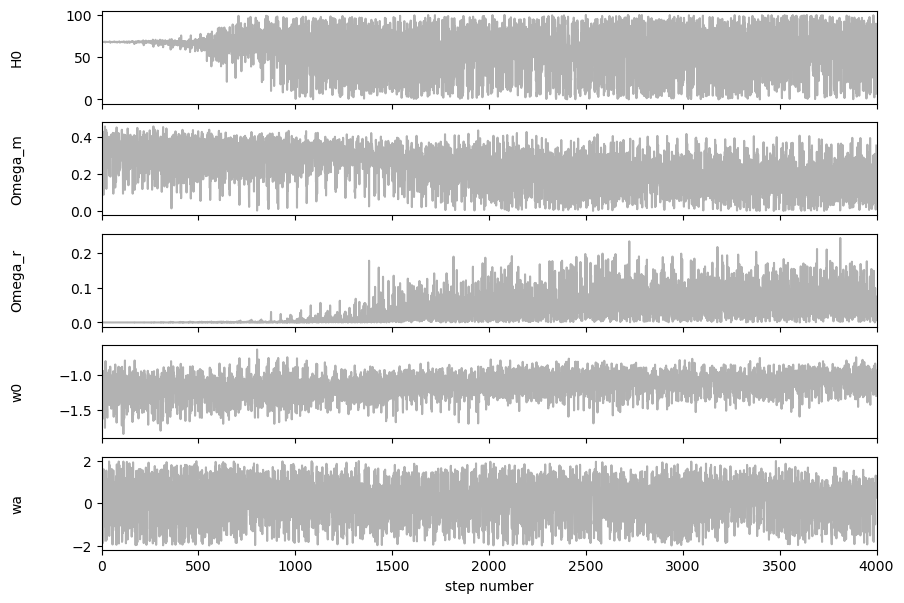

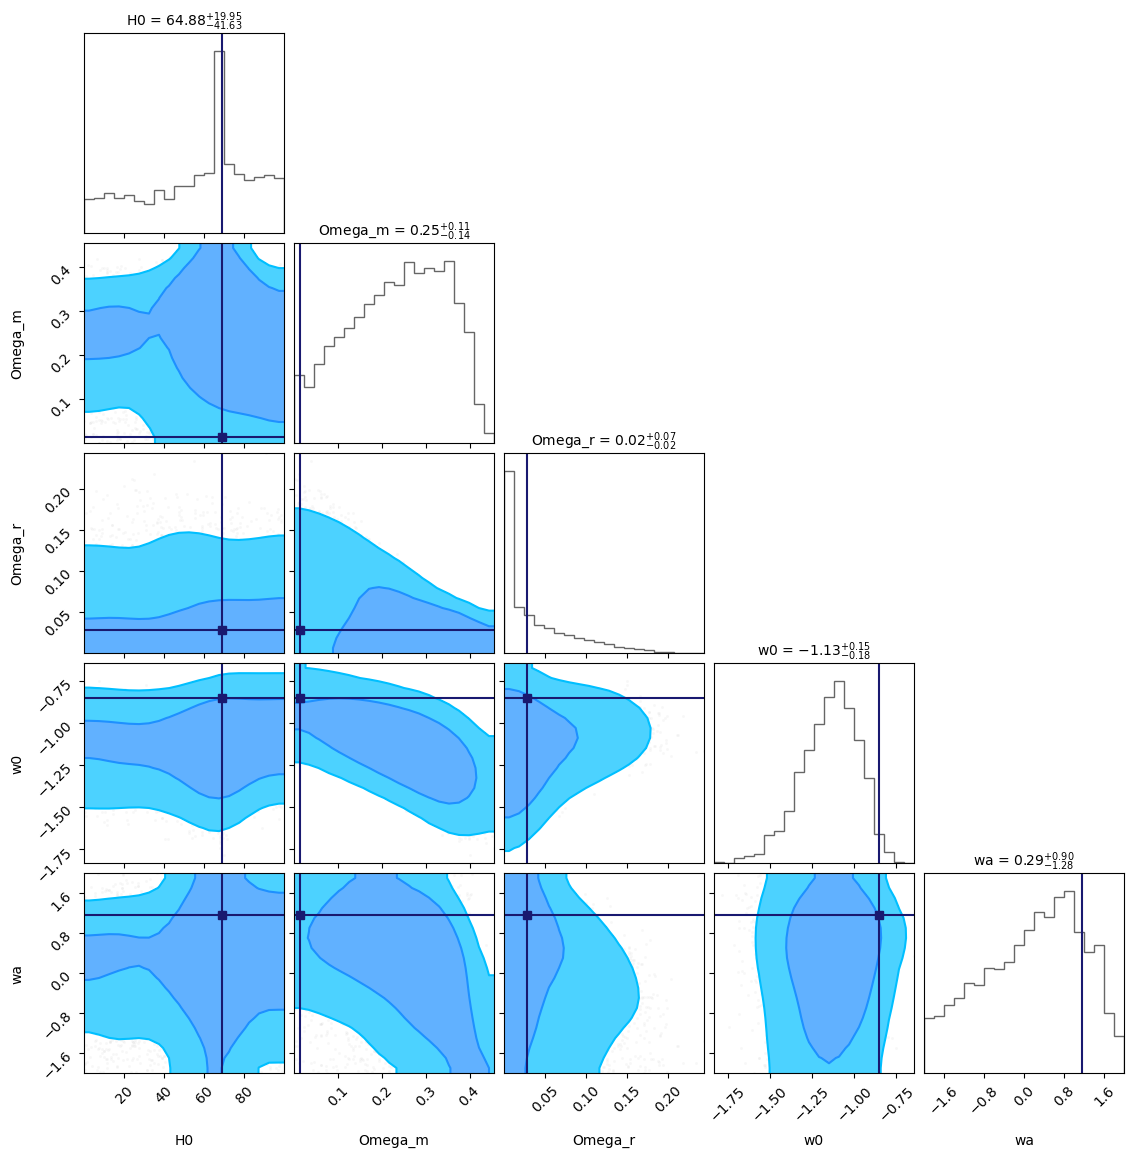

In [29]:
reshaped_samples = samples.reshape(-1, samples.shape[-1])

#i want to delete all the reshaped_samples with H0>100 and H0<40
#reshaped_samples=reshaped_samples[reshaped_samples[:,0]>60]
#reshaped_samples=reshaped_samples[reshaped_samples[:,0]<80]

#plot the chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["H0", "Omega_m", "Omega_r", "w0", "wa"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(reshaped_samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(reshaped_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

#'mediumvioletred'
#'hotpink', 'deeppink'

#'midnightblue'
#'deepskyblue', 'dodgerblue'

level_colors = ['deepskyblue', 'dodgerblue']

contourf_kwargs = {
    "colors": ['white', 'deepskyblue', 'dodgerblue'],  # Colors for the filled contours
    "alpha": 0.7  # Transparency of the filled contours
}
fig = corner.corner(reshaped_samples,
                    labels=labels,
                    truths=best_fit_params,
                    truth_color='midnightblue',
                    plot_contours=True,
                    fill_contours=True,
                    levels=[0.68, 0.95],
                    smooth=2.0,
                    show_titles=True,
                    title_fmt=".2f",
                    title_kwargs={"fontsize": 10},
                    hist_kwargs={"density": True, "alpha": 0.6},
                    contour_kwargs={"colors": level_colors},
                    contourf_kwargs=contourf_kwargs
                    )
    
plt.show()

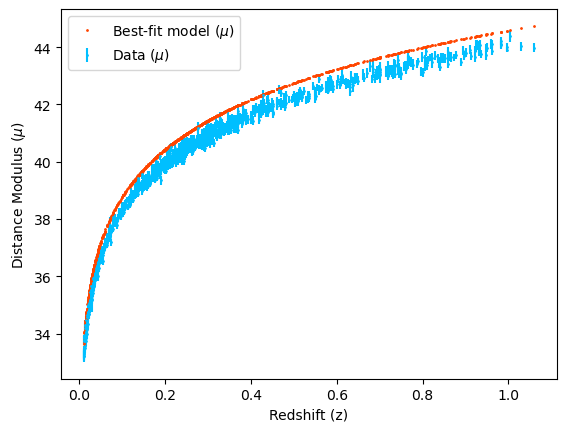

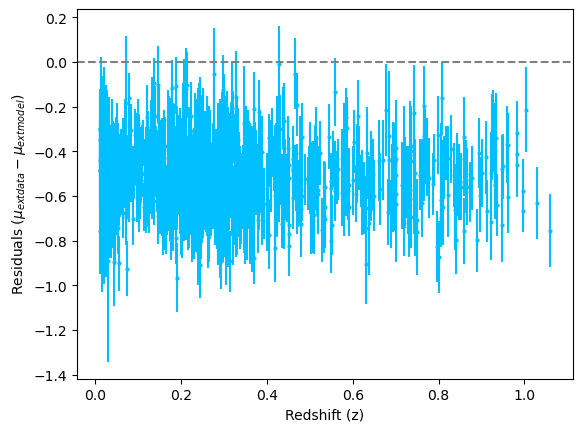

In [30]:
#plot the best fit model
best_fit_params_mcmc = np.mean(reshaped_samples, axis=0)
best_fit_params_mcmc_std = np.std(reshaped_samples, axis=0)
mu_model_best_mcmc = get_mu(z_data, *best_fit_params_mcmc)

plt.errorbar(z_data, mu_data, yerr=dmb, fmt='o', markersize=1, color='deepskyblue', label='Data ($\mu$)')
plt.plot(z_data, mu_model_best_mcmc, 'o', markersize=1, color='orangered', label='Best-fit model ($\mu$)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend()
plt.show()

#plot the residuals
residuals_mcmc = mu_data - mu_model_best_mcmc
plt.errorbar(z_data, residuals_mcmc, yerr=dmb, fmt='o', markersize=2, color='deepskyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals ($\mu_{\text{data}} - \mu_{\text{model}}$)')
plt.show()

In [31]:
print("--------------------------------------")
print("Best-fit parameters (MCMC):")
print("H0:", best_fit_params_mcmc[0], "+/-", best_fit_params_mcmc_std[0])
print("Omega_m:", best_fit_params_mcmc[1], "+/-", best_fit_params_mcmc_std[1])
print("Omega_r:", best_fit_params_mcmc[2], "+/-", best_fit_params_mcmc_std[2])
print("w0:", best_fit_params_mcmc[3], "+/-", best_fit_params_mcmc_std[3])
print("wa:", best_fit_params_mcmc[4], "+/-", best_fit_params_mcmc_std[4])
print("--------------------------------------")

--------------------------------------
Best-fit parameters (MCMC):
H0: 57.153233365880524 +/- 26.57695939337272
Omega_m: 0.23532557941598178 +/- 0.10881417092540072
Omega_r: 0.03811551720712504 +/- 0.04526616610297334
w0: -1.1456964410508934 +/- 0.16735530151444555
wa: 0.1645407636101018 +/- 0.9820239294512328
--------------------------------------


### Statistics

In [32]:
samples_H0 = reshaped_samples[:, 0]
samples_Omega_m = reshaped_samples[:, 1]
samples_Omega_r = reshaped_samples[:, 2]
samples_w0 = reshaped_samples[:, 3]
samples_wa = reshaped_samples[:, 4]

samples_dict = {
    "H0": samples_H0,
    "Omega_m": samples_Omega_m,
    "Omega_r": samples_Omega_r,
    "w0": samples_w0,
    "wa": samples_wa
}

for key, value in samples_dict.items():
    print(f"Mean of {key}: {np.mean(value)}")
    print(f"Standard deviation of {key}: {np.std(value)}")
    print(f"Median of {key}: {np.median(value)}")
    print(f"68% credible interval of {key}: {np.percentile(value, [16, 84])}")
    print(f"95% credible interval of {key}: {np.percentile(value, [2.5, 97.5])}")
    print(f"Skewness of {key}: {stats.skew(value)}")
    print(f"Kurtosis of {key}: {stats.kurtosis(value)}")
    print("--------------------------------------")

Mean of H0: 57.1532333658807
Standard deviation of H0: 26.57695939337274
Median of H0: 64.88257441536678
68% credible interval of H0: [23.25117288 84.8298226 ]
95% credible interval of H0: [ 4.12075674 97.01172059]
Skewness of H0: -0.4705898625615007
Kurtosis of H0: -0.7798416144558145
--------------------------------------
Mean of Omega_m: 0.23532557941598187
Standard deviation of Omega_m: 0.10881417092540063
Median of Omega_m: 0.2450583700688054
68% credible interval of Omega_m: [0.10953951 0.35308139]
95% credible interval of Omega_m: [0.0201552 0.4062001]
Skewness of Omega_m: -0.26756259315460534
Kurtosis of Omega_m: -0.8876993687263117
--------------------------------------
Mean of Omega_r: 0.03811551720712493
Standard deviation of Omega_r: 0.04526616610297329
Median of Omega_r: 0.01967976917570904
68% credible interval of Omega_r: [0.00032501 0.08627113]
95% credible interval of Omega_r: [1.11700307e-05 1.55241075e-01]
Skewness of Omega_r: 1.3259085949877152
Kurtosis of Omega_r: 

**N.B.:**

* positive skewness: the distribution has a long tail on the right side;
* negative skewness: the distribution has a long tail on the left side;
* kurtosis > 3: the distribution has heavy tails and a sharp peak, indicating a higher likelihood of extreme values;
* kurtosis < 3: the distribution has light tails and a flatter peak, indicating a lower likelihood of extreme values.